# DISCERN Tutorial

DiSCERN - Deep Single Cell Expression ReconstructioN can be used to reconstruct missing expression information using a reference data set.

In this tutorial, we'll apply DISCERN on two single cell RNAseq data sets to reconstruct expression information of the query data set (called citeseq here) and a reference data set (called pbmc8k).

Both data sets consist of PBMCs from Healthy Donors sequenced using the 10x Chromium technology. 
The pbmc8k data set is available [here](http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz) and will be downloaded automatically with the following functions.
The second data set, citeseq, was introduced in [Stoeckius et al. (2017)](https://www.nature.com/articles/nmeth.4380) and is available [here](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE100866&format=file&file=GSE100866_PBMC_vs_flow_10X-RNA_umi.csv.gz).
Additionally, to the transcriptomics information, this data set also contains Protein-Abundance information by Cite-Seq. However, the protein abundance is not used in this tutorial.

The tutorial consists of four parts:
1. Download
2. Data preprocessing
3. DiSCERN training and reconstruction
4. Basic inital analysis

In part 1 the example expression data and cell type information is downloaded from public websites.
In part 2 the preprocessing pipeline provided with DiSCERN is applied. This includes log-scaling and scaling of the data
In part 3 DiSCERN is trained and the applying DiSCERN the data sets. pbmc8k is used as a reference data set and the citeseq data set is reconstructed using information from the pbmc8k data set.
Finally, some basic downstream analysis steps, as UMAP and optionally clustering, are performed on the DiSCERN-reconstructed data.

In [1]:
import json
import pathlib

import discern
import matplotlib.pyplot as plt
import scanpy as sc

If discern is not available try installing it with:
```python
 pip install -U discern-reconstruction
```

## Download example data

This part is for downloading the example data. If you have already downloaded this data or plan to use your own data, you can skip this tutorial without any issues.

In [2]:
import json
import pathlib
import pickle
import tarfile
import tempfile

import anndata
import pandas as pd
import requests

In [3]:
def get_citeseq(counts, metadata):
    counts = pd.read_csv(counts, index_col=0)
    counts = counts.filter(like="HUMAN_", axis=0)
    counts.index = counts.index.str.replace("HUMAN_", "")
    counts = counts.T
    dataset = anndata.AnnData(X=counts)
    metadata = pd.read_csv(metadata).set_index("cellnames")
    clusterlist = {
        0: "CD4 T cells",
        1: "CD4 T cells",
        2: "NK cells",
        3: "CD14+ Monocytes",
        4: "B cells",
        5: "CD8 T cells",
        6: "FCGR3A+ Monocytes",
        7: "Other",
    }
    metadata["celltype"] = (
        metadata["cluster"].astype(int).replace(clusterlist).astype("category")
    )
    dataset.obs = pd.merge(
        dataset.obs, metadata, left_index=True, right_index=True, how="left"
    )
    dataset = dataset[dataset.obs.dropna().index]
    dataset = dataset[dataset.obs.celltype != "Other"].copy()
    return dataset

In [4]:
def get_8k(counts, metadata):
    with tempfile.TemporaryDirectory(dir=counts.parent) as tmp:
        with tarfile.open(counts, "r:gz") as file:
            file.extractall(tmp)
        matrixfile = list(pathlib.Path(tmp).rglob("matrix.mtx"))[0]
        dataset = sc.read_10x_mtx(matrixfile.parent)
    with pathlib.Path(metadata).open("rb") as file:
        metadata = pickle.load(file)
    df = pd.DataFrame(
        {"barcodes": metadata["barcodes"].index, "clusters": metadata["clusters"]}
    ).set_index("barcodes")
    df["celltype"] = pd.Categorical.from_codes(
        metadata["clusters"], metadata["list_clusters"]
    )
    dataset.obs = pd.merge(
        dataset.obs, df, left_index=True, right_index=True, how="left"
    )
    dataset = dataset[dataset.obs.dropna().index]
    dataset = dataset[dataset.obs.celltype != "Other"].copy()
    dataset.X = dataset.X.toarray()
    return dataset

In [5]:
def download(raw_folder="raw", data_path="data"):
    raw_folder = pathlib.Path(raw_folder)
    raw_folder.mkdir(exist_ok=True)
    data_path = pathlib.Path(data_path)
    data_path.mkdir(exist_ok=True)
    citeseq_data = raw_folder.joinpath("citeseq_data.csv.gz")
    citeseq_metadata = raw_folder.joinpath("citeseq_labels.csv")
    pbmc8k_data = raw_folder.joinpath("pbmc8k_data.tar.gz")
    pbmc8k_metadata = raw_folder.joinpath("pbmc8k_labels.pickle")
    if not citeseq_data.exists():
        r = requests.get(
            "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE100866&format=file&file=GSE100866_PBMC_vs_flow_10X-RNA_umi.csv.gz",
            allow_redirects=True,
        )
        citeseq_data.write_bytes(r.content)
    if not citeseq_metadata.exists():
        r = requests.get(
            "https://raw.githubusercontent.com/YosefLab/scVI-data/master/cite.seurat.labels",
            allow_redirects=True,
        )
        citeseq_metadata.write_bytes(r.content)
    if not pbmc8k_data.exists():
        r = requests.get(
            "http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz",
            allow_redirects=True,
        )
        pbmc8k_data.write_bytes(r.content)
    if not pbmc8k_metadata.exists():
        r = requests.get(
            "https://github.com/YosefLab/scVI-data/raw/master/pbmc_metadata.pickle",
            allow_redirects=True,
        )
        pbmc8k_metadata.write_bytes(r.content)
    citeseq = data_path.joinpath("citeseq.h5ad")
    if not citeseq.exists():
        get_citeseq(citeseq_data, citeseq_metadata).write(citeseq)
    pbmc8k = data_path.joinpath("pbmc8k.h5ad")
    if not pbmc8k.exists():
        get_8k(pbmc8k_data, pbmc8k_metadata).write(pbmc8k)

In [6]:
download()

## Loading and preprocessing

DiSCERN requires the training data in a format build upon [anndata.AnnData](https://anndata.readthedocs.io/en/latest/#) similar to [scanpy](https://scanpy.readthedocs.io/en/stable/).

Data set preparation requires a custom preprocessing involving library-size normalization, log-scaling and mean-variance-centering.
The preprocessing pipeline closely follows [Zheng et al. (2017)](https://www.nature.com/articles/ncomms14049).

The preprocessing pipeline is implemented in [`discern.WAERecipe`](https://discern.readthedocs.io/en/latest/api.html#discern.preprocessing.WAERecipe).

In [7]:
from discern import WAERecipe

Default parameters for this preprocessing and model training can be found in [`parameters.json`](https://github.com/imsb-uke/discern/blob/main/parameters.json). These parameters should work for most applications.

In [8]:
default_parameter = json.loads(pathlib.Path("parameters.json").read_bytes())[
    "experiments"
]["default_experiment"]

In this tutorial we used the dummy data downloaded by `download()` function above.
The data should be located in `data` directory, but a also custom data sets can be used.

The data sets can easily be read using [`sc.read`](https://scanpy.readthedocs.io/en/latest/generated/scanpy.read.html)

In [9]:
citeseq = sc.read("data/citeseq.h5ad")
pbmc8k = sc.read("data/pbmc8k.h5ad")

[`discern.WAERecipe`](https://discern.readthedocs.io/en/latest/api.html#discern.preprocessing.WAERecipe) requires the parameters as found in the `parameters.json` and 
two or more input data sets as dictionary.
The dictionary keys will be used as batch labels later for reconstruction.

In [10]:
recipe = WAERecipe(
    params=default_parameter, inputs={"citeseq": citeseq, "pbmc8k": pbmc8k}
)

After initializing the `WAERecipe` you can run the pipeline by calling and accessing the processed data using the `.sc_raw` attribute.
This will be used as input for DiSCERN model training. 

In [11]:
preprocessed_results = recipe().sc_raw

## DiSCERN reconstruction

### Create DiSCERN model

The discern model is implemented in the [`DISCERN`](https://discern.readthedocs.io/en/latest/api.html#discern.estimators.batch_integration.DISCERN) class and can be initialized directly from the default parameters, read from the `parameters.json` file above.

In [12]:
from discern import DISCERN

In [13]:
model = DISCERN.from_json(default_parameter)

As DISCERN is build on the [Tensorflow](https://www.tensorflow.org/) backend, the deep learning model needs to be initalized.
This can be achieved using the `build_model` function. It requires 3 arguments to to determine the input and output shapes:
- `n_nenes` which determines the input and output shape of the gene expression matrix.
- `n_labels` which indicates the number of datasets.
- `scale` which is a loss scaling factor, based on the total number of training samples, it is available in `preprocessed_results.config["total_train_count"]`.

In [14]:
model.build_model(
    n_genes=preprocessed_results.var_names.size,
    n_labels=preprocessed_results.obs.batch.nunique(),
    scale=preprocessed_results.config["total_train_count"],
)

If you're interested in the model details, you can uncomment the following lines, to see a brief description of the model structure.

In [15]:
# model.wae_model.summary() # Overall structure summary
# model.encoder.summary() # Encoder structure summary
# model.decoder.summary() # Decoder structure summary

### Train DiSCERN

The DISCERN model learns the gene regulatory network using the gene expression data. This is called "training".

To do so the data set is splitted into parts of smaller size, called mini-batches. 
The size of such a part needs to be set using the `batch_size` attribute. Usually 192 is a good choice but a higher or lower size can be choosen depending on the computational power.

In [16]:
preprocessed_results.batch_size = 192

The training can be performed using the `training` method.
 
The number of training steps (`max_steps`) is data set dependent and a higher value increase the running time, but up to a point, also the reconstruction quality.
Usually something around 30-50 is a good choice. Here it runs with 20 steps for computational reasons. 

The Commandline - API contains a more advanced method to determine the number of steps automatically (if defined in the `early_stopping` section of the `parameters.json` file).

In [17]:
losses = model.training(inputdata=preprocessed_results, max_steps=20)

Epoch 1/20
Epoch 1/20
66/66 - 41s - loss: 8785.4402 - decoder_counts_loss: 0.4685 - decoder_dropouts_loss: 0.1600 - mmdpp_loss: 0.1053 - sigma_regularization_loss: 480.2180 - val_loss: 6868.2529 - val_decoder_counts_loss: 0.4347 - val_decoder_dropouts_loss: 0.0023 - val_mmdpp_loss: 0.2171 - val_sigma_regularization_loss: 481.9739
Epoch 2/20
Epoch 1/20
66/66 - 34s - loss: 6519.8477 - decoder_counts_loss: 0.4317 - decoder_dropouts_loss: 0.0012 - mmdpp_loss: 0.0217 - sigma_regularization_loss: 482.5399 - val_loss: 6752.5207 - val_decoder_counts_loss: 0.4270 - val_decoder_dropouts_loss: 6.8104e-04 - val_mmdpp_loss: 0.2271 - val_sigma_regularization_loss: 482.5545
Epoch 3/20
Epoch 1/20
66/66 - 33s - loss: 6432.5845 - decoder_counts_loss: 0.4266 - decoder_dropouts_loss: 5.6044e-04 - mmdpp_loss: 0.0186 - sigma_regularization_loss: 481.4704 - val_loss: 6759.9067 - val_decoder_counts_loss: 0.4262 - val_decoder_dropouts_loss: 4.8755e-04 - val_mmdpp_loss: 0.2415 - val_sigma_regularization_loss: 4

The model losses, indicating the quality of the learned information, can be visualized from the resulting `losses` object. 

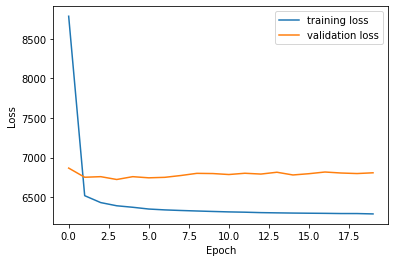

In [18]:
plt.plot(losses.epoch, losses.history["loss"], label="training loss")
plt.plot(losses.epoch, losses.history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Reconstruction with DiSCERN

Finally the preprocessed data can be reconstructed with the trained model.

Therefore the reference data set needs to be mentioned using a column available in `preprocessed_results.obs`.

In the usual case this column is `batch` and the reference batch is supplied by the `column_value` argment. Here we uses the `pbmc8k` data set as reference.

In [19]:
reconstructed_data = model.reconstruct(
    input_data=preprocessed_results,
    column="batch",
    column_value="pbmc8k",
)

The reconstructed data contains the latent representation of the expression data as computed by DiSCERN in `.obsm["X_DISCERN"]` and the reconstructed expression information in `.X`.
Additionally, Information about the estimated counts before applying the estimated dropouts can be found in `.layers`.

In [20]:
display(reconstructed_data.obsm)
reconstructed_data.layers

AxisArrays with keys: X_DISCERN

Layers with keys: estimated_counts, estimated_dropouts

## Visualization of reconstructed results

Finally the data can be analyzed with a standard pipeline, for example for data visulization.

Thus, we perform PCA and UMAP computation as implemented in `scanpy`. 
See [here](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) fore more information. 

In [21]:
sc.pp.pca(preprocessed_results)
sc.pp.pca(reconstructed_data)

In [22]:
sc.pp.neighbors(preprocessed_results)
sc.pp.neighbors(reconstructed_data)

In [23]:
sc.tl.umap(preprocessed_results)
sc.tl.umap(reconstructed_data)

... storing 'orig.ident' as categorical
... storing 'dataset' as categorical


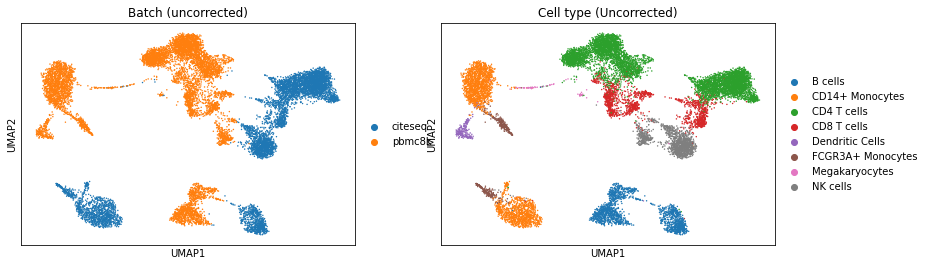

... storing 'orig.ident' as categorical
... storing 'dataset' as categorical


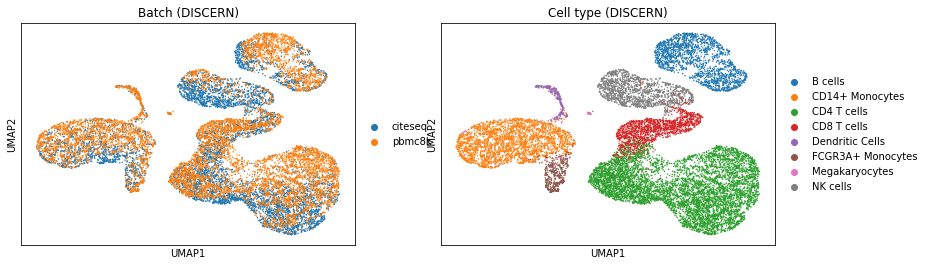

In [24]:
sc.pl.umap(
    preprocessed_results,
    color=["batch", "celltype"],
    title=["Batch (uncorrected)", "Cell type (Uncorrected)"],
)
sc.pl.umap(
    reconstructed_data,
    color=["batch", "celltype"],
    title=["Batch (DISCERN)", "Cell type (DISCERN)"],
)

## Optional: Cluster data after reconstruction

As an optional step, we show that with DISCERN integrated data it is easier to recover the originally identified cell types in the combined data set.

In [ ]:
pip install leidenalg # Required for running sc.tl.leiden but not installed by default

In [26]:
sc.tl.leiden(reconstructed_data, resolution=0.1)
sc.tl.leiden(preprocessed_results, resolution=0.1)

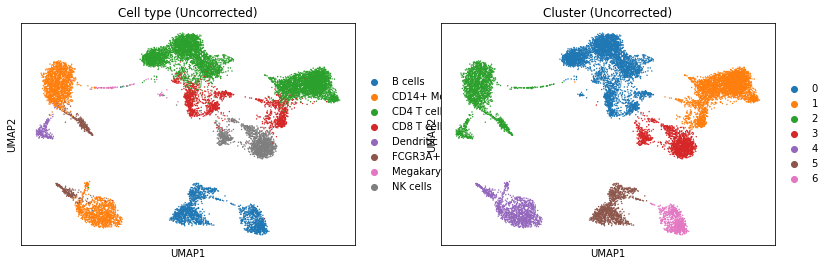

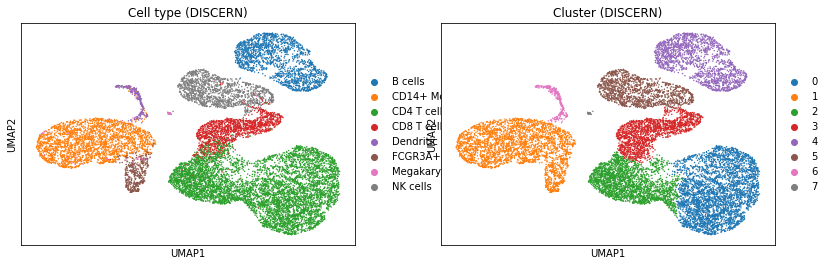

In [27]:
sc.pl.umap(
    preprocessed_results,
    color=["celltype", "leiden"],
    title=["Cell type (Uncorrected)", "Cluster (Uncorrected)"],
)
sc.pl.umap(
    reconstructed_data,
    color=["celltype", "leiden"],
    title=["Cell type (DISCERN)", "Cluster (DISCERN)"],
)